# Part 1: Train a 10-category animal classifier

In part 1, we will train a multi-class classifier which will later be used to do multi-instance learning based on on of these classes (dogs) being present in a bag of images.

Overall, this solution should be capable of detecting dogs in any complex image that is broken up into small frames of images containing other animals as well.

In [ ]:
!apt-get update
!pip3 install opencv-python

In [2]:
!apt install libgl1-mesa-glx -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libbsd0 libdrm-amdgpu1 libdrm-common libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libdrm2 libedit2 libelf1 libgl1 libgl1-mesa-dri libglapi-mesa
  libglvnd0 libglx-mesa0 libglx0 libllvm10 libpciaccess0 libsensors4 libx11-6
  libx11-data libx11-xcb1 libxau6 libxcb-dri2-0 libxcb-dri3-0 libxcb-glx0
  libxcb-present0 libxcb-sync1 libxcb1 libxdamage1 libxdmcp6 libxext6
  libxfixes3 libxshmfence1 libxxf86vm1
Suggested packages:
  pciutils lm-sensors
The following NEW packages will be installed:
  libbsd0 libdrm-amdgpu1 libdrm-common libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libdrm2 libedit2 libelf1 libgl1 libgl1-mesa-dri
  libgl1-mesa-glx libglapi-mesa libglvnd0 libglx-mesa0 libglx0 libllvm10
  libpciaccess0 libsensors4 libx11-6 libx11-data libx11-xcb1 libxau6
  libxcb-dri2-0 libxcb-dri3-0 libxcb-glx0 libxcb-present0 libxcb-sync1 libxcb1

7Progress: [ 13%] [#######...................................................] 8Selecting previously unselected package libelf1:amd64.
Preparing to unpack .../08-libelf1_0.170-0.4ubuntu0.1_amd64.deb ...
7Progress: [ 14%] [########..................................................] 8Unpacking libelf1:amd64 (0.170-0.4ubuntu0.1) ...
7Progress: [ 15%] [########..................................................] 8Selecting previously unselected package libdrm-common.
Preparing to unpack .../09-libdrm-common_2.4.101-2~18.04.1_all.deb ...
Unpacking libdrm-common (2.4.101-2~18.04.1) ...
7Progress: [ 16%] [#########.................................................] 87Progress: [ 17%] [#########.................................................] 8Selecting previously unselected package libdrm2:amd64.
Preparing to unpack .../10-libdrm2_2.4.101-2~18.04.1_amd64.deb ...
Unpacking libdrm2:amd64 (2.4.101-2~18.04.1) ...
7Progress: [ 18%] [##########............................................

7Progress: [ 52%] [##############################............................] 8Selecting previously unselected package libglx-mesa0:amd64.
Preparing to unpack .../31-libglx-mesa0_20.0.8-0ubuntu1~18.04.1_amd64.deb ...
7Progress: [ 53%] [##############################............................] 8Unpacking libglx-mesa0:amd64 (20.0.8-0ubuntu1~18.04.1) ...
7Progress: [ 55%] [###############################...........................] 8Selecting previously unselected package libglx0:amd64.
Preparing to unpack .../32-libglx0_1.0.0-2ubuntu2.3_amd64.deb ...
7Progress: [ 55%] [###############################...........................] 8Unpacking libglx0:amd64 (1.0.0-2ubuntu2.3) ...
7Progress: [ 56%] [################################..........................] 8Selecting previously unselected package libgl1:amd64.
Preparing to unpack .../33-libgl1_1.0.0-2ubuntu2.3_amd64.deb ...
Unpacking libgl1:amd64 (1.0.0-2ubuntu2.3) ...
7Progress: [ 57%] [#################################.......

In [109]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.utils import class_weight, shuffle

import tensorflow as tf

In [110]:
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

Dataset source: https://www.kaggle.com/alessiocorrado99/animals10

In [111]:
base_data_dir = './10_animal_categories/raw-img/'

foldernames = os.listdir(base_data_dir)
categories = []
files = []
i = 0

In [112]:
for k, folder in enumerate(foldernames):
    filenames = os.listdir(base_data_dir + folder)
    for file in filenames:
        files.append(base_data_dir + folder + "/" + file)
        categories.append(k)

In [113]:
# Create a dataframe with filepath and category (label)
df = pd.DataFrame({
    'filename': files,
    'category': categories
})

In [114]:
train_df = pd.DataFrame(columns=['filename', 'category'])

In [115]:
for i in range(10):
    train_df = train_df.append(df[df.category == i].iloc[:500,:]) # get 500 images from each of the 10 categories

In [116]:
train_df = train_df.reset_index(drop=True)

In [117]:
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse", "elephant" : "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", "ragno": "spider", "squirrel": "scoiattolo"}

In [118]:
# look up and translate label based on above dictionary
train_df['label'] = train_df.apply(lambda row: translate[row["filename"].split("/")[-2]], axis=1)

In [119]:
train_df.head()

,filename,category,label
0,./10_animal_categories/raw-img/farfalla/OIP-l7...,0,butterfly
1,./10_animal_categories/raw-img/farfalla/OIP-AD...,0,butterfly
2,./10_animal_categories/raw-img/farfalla/OIP-3A...,0,butterfly
3,./10_animal_categories/raw-img/farfalla/OIP-_y...,0,butterfly
4,./10_animal_categories/raw-img/farfalla/OIP-pT...,0,butterfly


In [120]:
category_to_animal_lable = pd.Series(train_df.label.values, index=train_df.category).to_dict()

In [121]:
category_to_animal_lable

{0: 'butterfly',
 1: 'chicken',
 2: 'cat',
 3: 'elephant',
 4: 'sheep',
 5: 'spider',
 6: 'dog',
 7: 'cow',
 8: 'squirrel',
 9: 'horse'}

In [122]:
x = train_df['filename']
y = train_df['category']

In [123]:
x, y = shuffle(x, y, random_state=2)

In [124]:
'''
This function centers the image around 256x256 pixels.
The outter edges, extending over 256 pixels, are trimmed by half 
Next, the image is fitted into a 256x256 window
'''
def center_img(img):
    size = [256, 256]
    img_size = img.shape[:2]
    
    row = (size[1] - img_size[0]) // 2  # in the case that row is a negative value, it affects the 
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img
    return resized

In [125]:
images = []

'''
Loop through all the images, convert the short side (h, w) 
to be 256 pixel. Shrink the larger side while maintaining 
the aspect ratio
'''
with tqdm(total=len(train_df)) as pbar:
    for i, file_path in enumerate(train_df.filename.values):
        #read image
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # resize -- keeping the aspect ratio of the larger side
        if (img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]), 256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))
            
        img = center_img(cv2.resize(img, dsize=tile_size))
        
        img = img[16:240, 16:240]
        images.append(img)
        pbar.update(1)
        
images = np.array(images)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


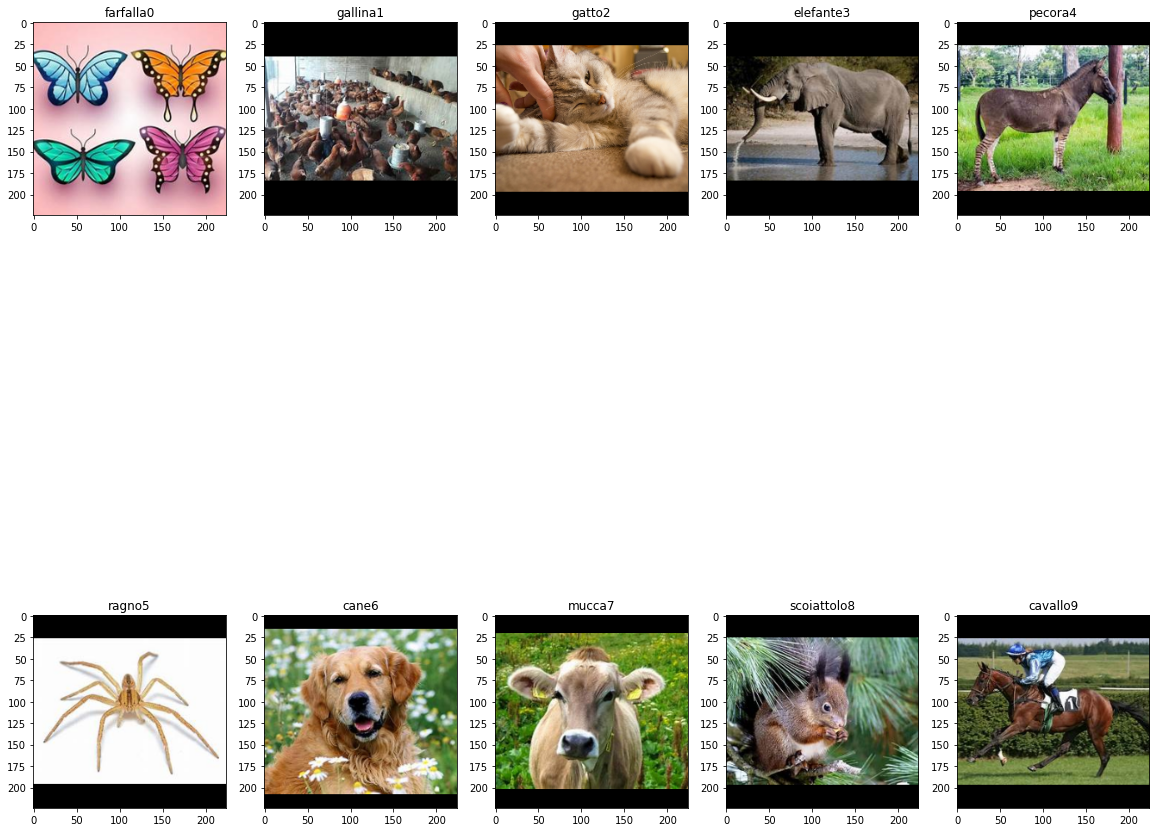

In [126]:
rows, cols = 2,5
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,20))

for i in range(10):
    path = train_df[train_df.category == i].values[2] # get path from 3rd column
    
    axes[i//cols, i%cols].set_title(path[0].split('/')[3] + str(path[1])) # Set title based on folder name
    axes[i//cols, i%cols].imshow(images[train_df[train_df.filename == path[0]].index[0]]) # Set cell data based on path

In [127]:
y

3566    7
4252    8
1918    3
4111    8
1471    2
       ..
3335    6
1099    2
2514    5
3606    7
2575    5
Name: category, Length: 5000, dtype: object

In [128]:
# x and y are variables with image path and folder number, respectively

x_shuffle = []
y_shuffle = []

random_index = np.random.permutation(len(y))

for i in range(len(y)):
    x_shuffle.append(images[random_index[i]])
    y_shuffle.append(y[random_index[i]])
    
x = np.array(x_shuffle)
y = np.array(y_shuffle)

val_split_num = int(round(0.2 * len(y)))
x_train = x[val_split_num:]
y_train = y[val_split_num:]
x_test = x[:val_split_num]
y_test = y[:val_split_num]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

x_train (4000, 224, 224, 3)
y_train (4000,)
x_test (1000, 224, 224, 3)
y_test (1000,)


In [129]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [130]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [131]:
img_rows, img_cols, img_channels = 224, 224, 3

# Create RestNet Model for Classification

In [134]:
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channels))

add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(10, activation='softmax'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])

model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [135]:
'''
batch_size = 32
epochs = 25

train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
train_datagen.fit(x_train)

history = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size),
                             steps_per_epoch=x_train.shape[0] // batch_size,
                              epochs=epochs,
                              validation_data=(x_test, y_test),
                              callbacks=[ModelCheckpoint('VGG-transferlearning.model', monitor='val_acc')]
                             )
'''

Epoch 1/25
125/125 [==============================] - ETA: 0s - loss: 0.3275 - accuracy: 0.1357WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: VGG-transferlearning.model/assets
125/125 [==============================] - 68s 543ms/step - loss: 0.3275 - accuracy: 0.1357 - val_loss: 0.3149 - val_accuracy: 0.1920
Epoch 2/25
125/125 [==============================] - 68s 540ms/step - loss: 0.3102 - accuracy: 0.2237 - val_loss: 0.3011 - val_accuracy: 0.2790
Epoch 3/25
125/125 [==============================] - 67s 534ms/step - loss: 0.2966 -

CNN: Epochs=25, Train accuracy=0.88150, Validation accuracy=0.86400


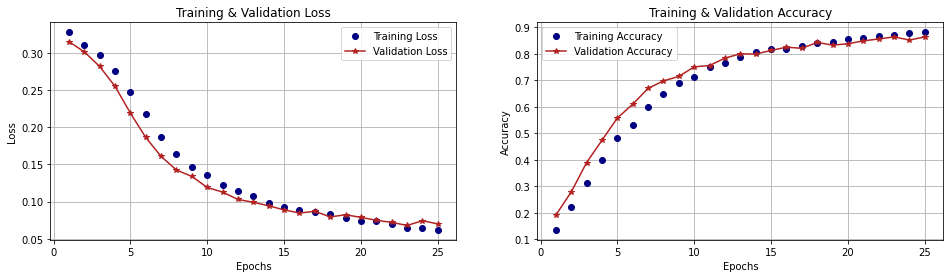

In [136]:
print("CNN: Epochs={0:d}, Train accuracy={1:.5f}, Validation accuracy={2:.5f}".format(epochs,history.history['accuracy'][epochs-1],history.history['val_accuracy'][epochs-1]))
def show_plots(history):
    """ Useful function to view plot of loss values & accuracies across the various epochs """
    loss_vals = history['loss']
    val_loss_vals = history['val_loss']
    epochs = range(1, len(history['accuracy'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    # plot losses on ax[0]
    ax[0].plot(epochs, loss_vals, color='navy',marker='o', linestyle=' ', label='Training Loss')
    ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    # plot accuracies
    acc_vals = history['accuracy']
    val_acc_vals = history['val_accuracy']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    # delete locals from heap before exiting
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals
show_plots(history.history)

In [161]:
saved_pretrain_model = tf.keras.models.load_model("VGG-transferlearning.model")

In [162]:
loss,acc = saved_pretrain_model.evaluate(x_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

32/32 - 4s - loss: 0.0699 - accuracy: 0.8640
Restored model, accuracy: 86.40%


# Create Bags of images for MIL

In [139]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(4000, 224, 224, 3) (4000, 10)
(1000, 224, 224, 3) (1000, 10)


In [140]:
# Get the original categorical labels 
_y_train = y[val_split_num:]
_y_test = y[:val_split_num]

In [141]:
np.unique(_y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [142]:
instance_index_label = [(i, _y_train[i]) for i in range(x_train.shape[0])]
instance_index_label_test = [(i, _y_test[i]) for i in range(x_test.shape[0])]

In [143]:
# find the index of dog images (label 0)
find_index = [instance_index_label[i][0] for i in range(len(instance_index_label)) if instance_index_label[i][1]==0]

In [144]:
# find the index of dog images (label 0)
find_index_test = [instance_index_label_test[i][0] for i in range(len(instance_index_label_test))
                   if instance_index_label_test[i][1]==0]

In [145]:
# Function reference: https://github.com/lsheng23/Practicum/blob/master/MIL_MNIST/end_to_end_mnist_MIL.ipynb
import copy
from typing import List, Dict, Tuple
def data_generation(instance_index_label: List[Tuple]) -> List[Dict]:
    """
    bags: {key1: [ind1, ind2, ind3],
           key2: [ind1, ind2, ind3, ind4, ind5],
           ... }
    bag_lbls:
        {key1: 0,
         key2: 1,
         ... }
    """
    bag_size = np.random.randint(3,7,size=len(instance_index_label)//5)
    data_cp = copy.copy(instance_index_label)
    np.random.shuffle(data_cp)
    bags = {}
    bags_per_instance_labels = {}
    bags_labels = {}
    for bag_ind, size in enumerate(bag_size):
        bags[bag_ind] = []
        bags_per_instance_labels[bag_ind] = []
        try:
            for _ in range(size):
                inst_ind, lbl = data_cp.pop()
                bags[bag_ind].append(inst_ind)
                # simplfy, just use a temporary variable instead of bags_per_instance_labels
                bags_per_instance_labels[bag_ind].append(lbl)
            bags_labels[bag_ind] = bag_label_from_instance_labels(bags_per_instance_labels[bag_ind])
        except:
            break
    return bags, bags_labels

def bag_label_from_instance_labels(instance_labels):
    return int(any(((x==0) for x in instance_labels)))

### Create bags with training 

In [146]:
bag_indices, bag_labels = data_generation(instance_index_label) # which image is which label

In [147]:
bag_indices

{0: [2180, 545, 2615, 3316, 2256],
 1: [3971, 3784, 3306, 1230, 1927, 2153],
 2: [3422, 3350, 531, 2873, 2785, 3315],
 3: [1887, 18, 3616],
 4: [2464, 2263, 1391, 2845],
 5: [1344, 1394, 3839],
 6: [2378, 2770, 2903, 1413],
 7: [687, 1410, 3189, 2848],
 8: [689, 2380, 8, 1891, 1450, 3762],
 9: [3645, 508, 3466, 670, 2591, 1401],
 10: [3396, 2372, 1641, 2086, 1789],
 11: [3204, 382, 1731, 1079],
 12: [3997, 3658, 2012, 2313, 554, 3456],
 13: [2809, 1962, 957],
 14: [1237, 2460, 2137, 360, 2756, 761],
 15: [1196, 2253, 2119, 3212],
 16: [3450, 675, 2462, 392, 207],
 17: [2773, 819, 3786],
 18: [3697, 3967, 1047, 3650, 2622],
 19: [1588, 377, 1190, 121, 532, 2587],
 20: [2539, 2642, 788, 1176, 3287],
 21: [1158, 2099, 2031, 1905, 3602],
 22: [3621, 73, 3046],
 23: [3980, 3343, 106, 755],
 24: [1620, 3811, 3437, 500],
 25: [78, 2429, 2869, 2187, 2768],
 26: [394, 3966, 2598, 3647],
 27: [887, 2890, 1546, 1327],
 28: [536, 769, 1738, 1303, 2342, 1477],
 29: [367, 2377, 3927],
 30: [3146, 63

In [148]:
bag_labels

{0: 1,
 1: 0,
 2: 1,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 1,
 19: 0,
 20: 1,
 21: 0,
 22: 0,
 23: 1,
 24: 0,
 25: 1,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 1,
 32: 1,
 33: 0,
 34: 1,
 35: 1,
 36: 0,
 37: 1,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 1,
 44: 0,
 45: 0,
 46: 1,
 47: 1,
 48: 0,
 49: 0,
 50: 0,
 51: 0,
 52: 0,
 53: 1,
 54: 1,
 55: 0,
 56: 0,
 57: 0,
 58: 0,
 59: 0,
 60: 1,
 61: 0,
 62: 0,
 63: 1,
 64: 1,
 65: 1,
 66: 0,
 67: 0,
 68: 0,
 69: 0,
 70: 1,
 71: 1,
 72: 0,
 73: 1,
 74: 0,
 75: 1,
 76: 0,
 77: 1,
 78: 0,
 79: 1,
 80: 0,
 81: 0,
 82: 0,
 83: 1,
 84: 0,
 85: 0,
 86: 1,
 87: 1,
 88: 0,
 89: 1,
 90: 0,
 91: 1,
 92: 0,
 93: 0,
 94: 1,
 95: 0,
 96: 1,
 97: 1,
 98: 0,
 99: 0,
 100: 1,
 101: 0,
 102: 0,
 103: 1,
 104: 1,
 105: 0,
 106: 0,
 107: 1,
 108: 0,
 109: 1,
 110: 1,
 111: 0,
 112: 1,
 113: 0,
 114: 1,
 115: 0,
 116: 0,
 117: 0,
 118: 1,
 119: 0,
 120: 1,
 121: 0,
 122: 0,
 12

In [149]:
bag_features = {kk: x_train[inds] for kk, inds in bag_indices.items()} #

In [150]:
train_data = [(bag_features[i], bag_labels[i]) for i in range(len(bag_features))]

In [151]:
bag_features[0].shape
# does this need to be padded or re-shaped to be [3, x] in size?

(5, 224, 224, 3)

### Create bags with test data

In [152]:
bag_t_indices, bag_t_labels = data_generation(instance_index_label_test) # which image is which label

In [153]:
bag_t_features = {kk: x_test[inds] for kk, inds in bag_t_indices.items()} #

In [154]:
# train using the bag based approach

In [155]:
test_images = np.array(bag_features[0]).reshape(-1,224,224,3)

In [156]:
test_images.shape

(5, 224, 224, 3)

In [157]:
something = saved_pretrain_model.predict(test_images)

In [158]:
something

array([[3.4195409e-04, 6.4004296e-01, 5.6574558e-04, 1.0172875e-03,
        3.5344338e-01, 3.8559145e-05, 1.5610394e-04, 1.1178425e-05,
        4.3795779e-03, 3.1758582e-06],
       [3.4174995e-04, 3.6030729e-06, 9.9909854e-01, 1.3037399e-06,
        7.1182054e-05, 4.5601195e-07, 4.1250541e-04, 6.3630200e-06,
        5.1949875e-05, 1.2358431e-05],
       [4.2499337e-06, 1.8428471e-04, 6.6329500e-05, 5.6888493e-05,
        8.3198771e-02, 3.8698399e-05, 2.0106049e-02, 4.4425774e-01,
        6.9426553e-04, 4.5139280e-01],
       [4.9712078e-04, 5.0827151e-07, 2.3253862e-07, 9.8810531e-08,
        6.6385439e-07, 9.9948370e-01, 2.3443062e-07, 4.4515042e-07,
        8.9835039e-06, 7.9004940e-06],
       [9.5981824e-01, 1.0362650e-04, 3.8066511e-05, 1.4407051e-06,
        5.1239404e-06, 3.9053742e-02, 5.5506511e-04, 3.8789698e-05,
        3.3360935e-04, 5.2316602e-05]], dtype=float32)

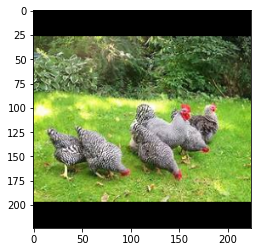

Actual  : chicken
Predict : chicken


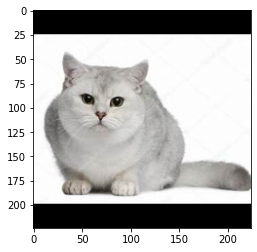

Actual  : cat
Predict : cat


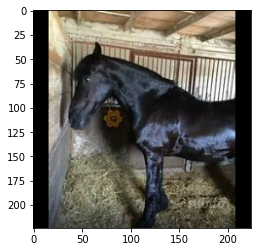

Actual  : horse
Predict : horse


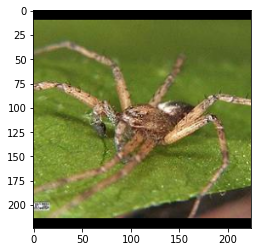

Actual  : spider
Predict : spider


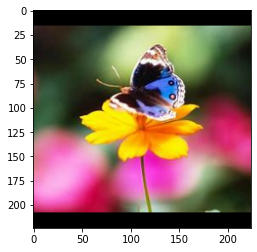

Actual  : butterfly
Predict : butterfly


In [163]:
i=0
for pred in something:
    path = train_df[train_df.category == i].values[2]
    plt.imshow(test_images[i])
    plt.show()
    print('Actual  :', category_to_animal_lable[_y_train[bag_indices[0][i]]])
    print('Predict :', category_to_animal_lable[np.where(pred.max() == pred)[0][0]])
    i += 1

In [100]:
_y_train[bag_indices[0][2]]

8

In [102]:
something[1].max() == something[1]

array([False, False, False, False, False, False, False,  True, False,
       False])